### Helsingborg Flowcytometry e.coli prediction using ML

In [1]:
import sys

if sys.version_info.major == 3 and sys.version_info.minor >= 10:
    import collections
    setattr(collections, "MutableMapping", collections.abc.MutableMapping)

#!pip install mpl_interactions

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [5]:
import sys

assert sys.version_info >= (3, 7)

In [7]:
# libraries and file pointers
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import FlowCytometryTools
from FlowCytometryTools import test_data_dir,test_data_file
datadir=test_data_dir
datafile=test_data_file
from FlowCytometryTools import FCMeasurement
import os

from sklearn.ensemble import RandomForestClassifier
#ran_for=RandomForestClassifier(n_estimators=100,max_depth=1)
ran_for=RandomForestClassifier(n_estimators=1500)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(max_iter=1000,penalty="none")

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

datafolder='data2/'
pixels=8  # pixels*pixels,(best with 8)  hyperparameter Pixel=1 correspond to TCC
reruns=500


### Load Dataframe with fcs data (log'd, gated and windowed)

In [9]:
samples=os.listdir('./data2')
Df=pd.DataFrame(np.zeros([len(samples),pixels*pixels]),index=samples)
kolumner=list(Df.columns.values)
nyakolumner=[]
for i in range(len(kolumner)):
  nyakolumner.append('V'+str(i))
Df.columns=nyakolumner
Df['ECOLI']=np.nan
for i in range(len(samples)):
    datafile=datafolder+samples[i]
    sample=FCMeasurement(ID='Test Sample',datafile=datafile)    
    frame=sample.data
    frame2=frame[['FL1-A','FL3-A']]
    frame3=frame2.replace(to_replace=0,value=1)
    frame4=np.log10(frame3)
    framefiltered=frame4[(frame4['FL1-A']>=3.3) & (frame4['FL1-A']<=6) & 
                     (frame4['FL3-A']>=1) & (frame4['FL3-A']<= ( 3 + ((5-3)/(6-3.3))*(frame4['FL1-A']-3.3) ) )  ]
    for y in range(pixels):
        for x in range(pixels):
            winminx=3.3+ ((6-3.3)/pixels)*x
            winmaxx=(3.3+ ((6-3.3)/pixels) ) + ((6-3.3)/pixels)*x        
            winminy=(5-  (5-1)/pixels ) - ((5-1)/pixels)*y
            winmaxy=5 - ((5-1)/pixels)*y
            Df.iloc[i,(x+y*pixels)]= framefiltered[(framefiltered['FL1-A']>=winminx) & (framefiltered['FL1-A']<winmaxx) & 
                                (framefiltered['FL3-A']>=winminy) & (framefiltered['FL3-A']< winmaxy ) ].shape[0]
Df

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,ECOLI
A02 B1 1-20 a v28 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,32.0,17.0,0.0,0.0,...,0.0,34.0,12.0,7.0,3.0,0.0,0.0,0.0,0.0,NaN
A02 B1 1-20 a v29 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,...,0.0,13.0,4.0,7.0,1.0,0.0,0.0,0.0,0.0,NaN
A02 B1 1-20 a v30 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,8.0,18.0,0.0,0.0,...,0.0,15.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,NaN
A02 B1 1-20 a v31 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,0.0,0.0,...,0.0,15.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,NaN
A02 B1 1-20 a v32 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,0.0,...,0.0,9.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B06 B6 1-20 c v31 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
B06 B6 1-20 c v32 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,0.0,0.0,...,0.0,6.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,NaN
B06 B6 1-20 c v33 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,...,0.0,12.0,12.0,7.0,1.0,0.0,0.0,0.0,0.0,NaN
B06 B6 1-20 c v34 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,10.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0,NaN


### ECOLI column:

In [11]:
metadata=pd.read_excel('Summer 2020 FCS files with metadata_2.xlsx')
metadata=metadata.iloc[1:,[2,3,4,5,16]]
metadata.columns=['loc','SY_file_1','SY_file_2','SY_file_3','ECOLI']
metadata=metadata[metadata['loc'].isin(['B1','B2','B3','B4','B5','B6'])]
metadata=metadata.dropna()
metadata_v28=metadata.loc[125:128,:]
metadata_v29=metadata.loc[[145]]
metadata_v30_v35=metadata.loc[168:290,:]
metadata2=pd.concat([metadata_v28,metadata_v29,metadata_v30_v35],axis=0)
for i in range(len(Df)):
    s=Df.index[i]; s2=s.replace('.fcs','')
    x=metadata.apply(lambda row: row.astype(str).str.contains(s2).any(), axis=1)    
    if np.where(x)[0].size > 0:
        Df.iloc[i,(Df.shape[1]-1)]=metadata.iloc[np.where(x)[0].astype('int')[0],(metadata.shape[1]-1)]
Df['y/n']=1
Df.loc[Df[Df['ECOLI']>100].index , 'y/n']=2
#Df.iloc[:,85:]
Df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V56,V57,V58,V59,V60,V61,V62,V63,ECOLI,y/n
A02 B1 1-20 a v28 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,32.0,17.0,0.0,0.0,...,34.0,12.0,7.0,3.0,0.0,0.0,0.0,0.0,1100.0,2
A02 B1 1-20 a v29 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,...,13.0,4.0,7.0,1.0,0.0,0.0,0.0,0.0,200.0,2
A02 B1 1-20 a v30 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,8.0,18.0,0.0,0.0,...,15.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,246.0,2
A02 B1 1-20 a v31 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,0.0,0.0,...,15.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,10.0,1
A02 B1 1-20 a v32 SY.fcs,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,0.0,...,9.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,6870.0,2


In [13]:
samples_short=samples.copy() #shorter filenames for plotting
for i in range(40):
    samples_short[i]=samples_short[i][5:6]+samples_short[i][16:17]
samples_short2=np.array(samples_short)
samples_short2    

array(['18', '19', '10', '11', '12', '13', '14', '15', '48', '40', '41',
       '42', '43', '44', '45', '18', '19', '10', '11', '12', '13', '14',
       '15', '48', '40', '41', '42', '43', '44', '45', '18', '19', '10',
       '11', '12', '13', '14', '15', '48', '40',
       'A04 B4 1-20 c v31 SY.fcs', 'A04 B4 1-20 c v32 SY.fcs',
       'A04 B4 1-20 c v33 SY.fcs', 'A04 B4 1-20 c v34 SY.fcs',
       'A04 B4 1-20 c v35 SY.fcs', 'A06 B2 1-20 a v28 SY.fcs',
       'A06 B2 1-20 a v30 SY.fcs', 'A06 B2 1-20 a v31 SY.fcs',
       'A06 B2 1-20 a v32 SY.fcs', 'A06 B2 1-20 a v33 SY.fcs',
       'A06 B2 1-20 a v34 SY.fcs', 'A06 B5 1-20 a v30 SY.fcs',
       'A06 B5 1-20 a v31 SY.fcs', 'A06 B5 1-20 a v32 SY.fcs',
       'A06 B5 1-20 a v33 SY.fcs', 'A06 B5 1-20 a v34 SY.fcs',
       'A06 B5 1-20 a v35 SY.fcs', 'B01 B2 1-20 b v28 SY.fcs',
       'B01 B2 1-20 b v30 SY.fcs', 'B01 B2 1-20 b v31 SY.fcs',
       'B01 B2 1-20 b v32 SY.fcs', 'B01 B2 1-20 b v33 SY.fcs',
       'B01 B2 1-20 b v34 SY.fcs', 'B01

In [15]:
Df['y/n'].value_counts()

y/n
2    60
1    60
Name: count, dtype: int64

In [17]:
Df2=Df.drop('ECOLI',axis=1)

In [19]:
Df2.reset_index(drop=True, inplace=True)
Df2

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,17.0,0.0,0.0,...,0.0,34.0,12.0,7.0,3.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,...,0.0,13.0,4.0,7.0,1.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,8.0,18.0,0.0,0.0,...,0.0,15.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,0.0,0.0,...,0.0,15.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,0.0,...,0.0,9.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
116,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,0.0,0.0,...,0.0,6.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,2
117,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.0,0.0,...,0.0,12.0,12.0,7.0,1.0,0.0,0.0,0.0,0.0,1
118,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,10.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0,1


## Visualization, PCA Raw data

In [21]:
principalComponents = pca.fit_transform(Df2.iloc[:,0:-1])
PCA_df2=pd.DataFrame(principalComponents)
finalDf2 = pd.concat([PCA_df2,Df2.iloc[:,-1]], axis = 1)
finalDf2["samples"]=samples_short2
kvalitet=100*pca.explained_variance_ratio_
kvalitet_PCA1 = str(int(kvalitet[0]))
kvalitet_PCA2 = str(int(kvalitet[1]))

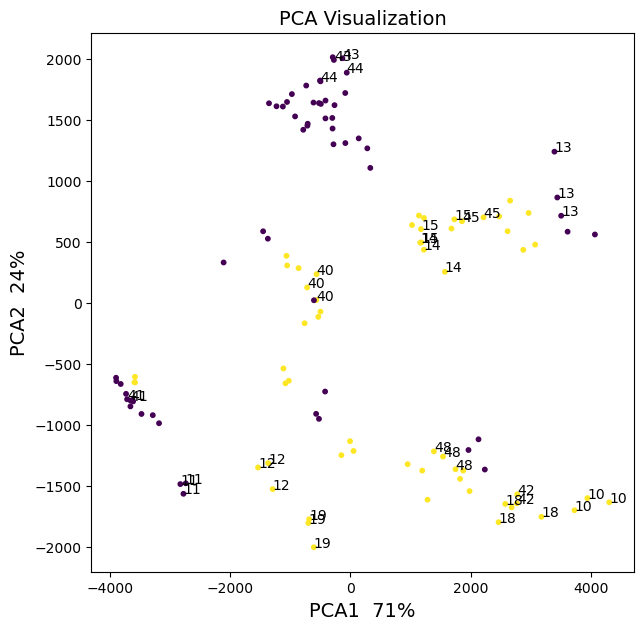

In [23]:
with plt.ioff():
    figure, axis = plt.subplots(figsize=(7,7))
plt.xlabel("PCA1"+"  "+kvalitet_PCA1+ "%")
plt.ylabel("PCA2"+"  "+kvalitet_PCA2+ "%")
plt.title("PCA Visualization")
plt.scatter(finalDf2.iloc[:,0],finalDf2.iloc[:,1],c=finalDf2.iloc[:,2],s=10)
for i in range(40):
    plt.text(finalDf2.iloc[i,0],finalDf2.iloc[i,1],finalDf2.iloc[i,3],fontsize=10)
#disconnect_zoom = zoom_factory(axis)
#pan_handler = panhandler(figure)
#display(figure.canvas)

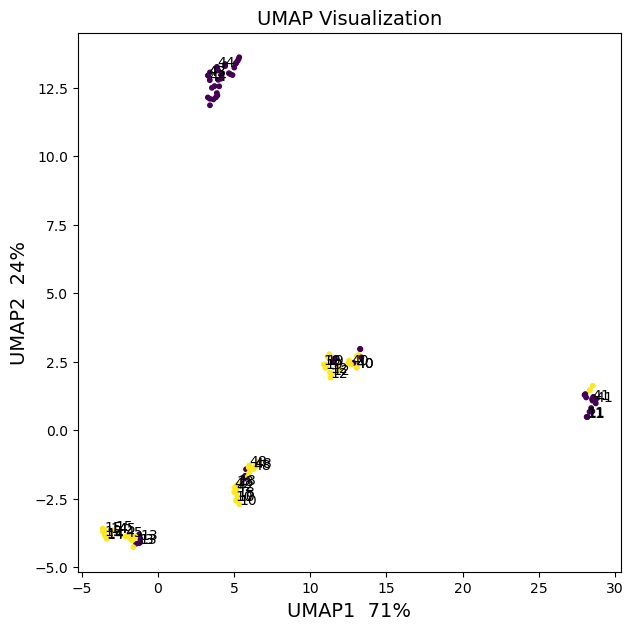

In [27]:
import matplotlib.pyplot as plt
import umap

# Make sure to define them properly if not already done
with plt.ioff():
    figure, axis = plt.subplots(figsize=(7, 7))
    plt.xlabel("UMAP1" + "  " + kvalitet_PCA1 + "%")
    plt.ylabel("UMAP2" + "  " + kvalitet_PCA2 + "%")
    plt.title("UMAP Visualization")
    
    # Perform UMAP dimensionality reduction
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(finalDf2.iloc[:, :2])  # Assuming you want to reduce to 2 dimensions
    
    # Scatter plot the UMAP results
    plt.scatter(embedding[:, 0], embedding[:, 1], c=finalDf2.iloc[:, 2], s=10)
    
    # Annotate points with labels
    for i in range(40):
        plt.text(embedding[i, 0], embedding[i, 1], finalDf2.iloc[i, 3], fontsize=10)
    
    plt.show()


### Normalized features , remove feature magnitude

In [68]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(Df2.iloc[:,0:-1])
df3_norm_indata=pd.DataFrame(data=x) 
df3_norm = pd.concat([df3_norm_indata, Df2.iloc[:,-1]], axis = 1)
df3_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,4.514084,1.942978,0.0,0.0,...,0.0,3.723966,2.608709,0.617994,1.090596,-0.09167,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.068171,-0.782946,0.0,0.0,...,0.0,0.000000,-0.243638,0.617994,-0.324231,-0.09167,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.246007,2.124707,0.0,0.0,...,0.0,0.354663,-0.600181,-0.987185,0.383183,-0.09167,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.957353,0.670880,0.0,0.0,...,0.0,0.354663,-0.956725,0.296958,-0.324231,-0.09167,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.313026,1.034337,0.0,0.0,...,0.0,-0.709327,-0.243638,-0.345114,-1.031645,-0.09167,0.0,0.0,0.0,2


In [69]:
principalComponents3 = pca.fit_transform(df3_norm.iloc[:,0:-1])
PCA_df3=pd.DataFrame(principalComponents3)
finaldf3 = pd.concat([PCA_df3,df3_norm.iloc[:,-1]], axis = 1)
finaldf3["samples"]=samples_short2

In [70]:
kvalitet=100*pca.explained_variance_ratio_
kvalitet_PCA1 = str(int(kvalitet[0]))
kvalitet_PCA2 = str(int(kvalitet[1]))

<IPython.core.display.Javascript object>


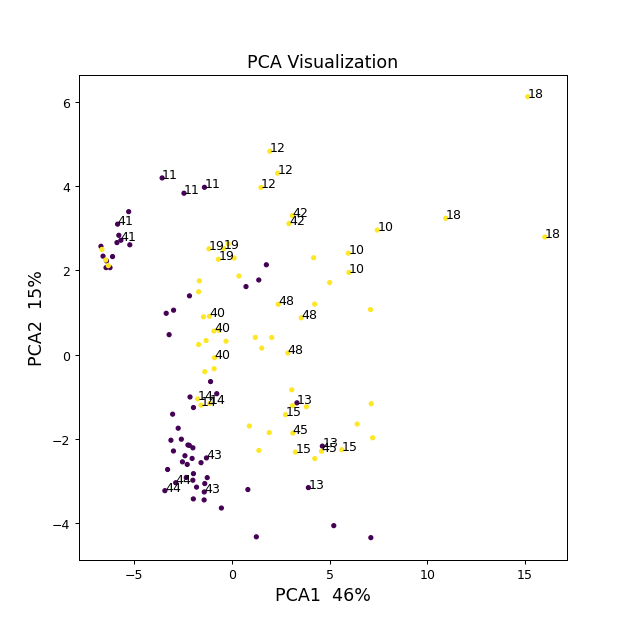

In [71]:
with plt.ioff():
    figure, axis = plt.subplots(figsize=(7,7))
plt.xlabel("PCA1"+"  "+kvalitet_PCA1+ "%")
plt.ylabel("PCA2"+"  "+kvalitet_PCA2+ "%")
plt.title("PCA Visualization")
plt.scatter(finaldf3.iloc[:,0],finaldf3.iloc[:,1],c=finaldf3.iloc[:,2],s=10)
for i in range(40):
    plt.text(finaldf3.iloc[i,0],finaldf3.iloc[i,1],finaldf3.iloc[i,3],fontsize=10)
#disconnect_zoom = zoom_factory(axis)
#pan_handler = panhandler(figure)
display(figure.canvas)
figure

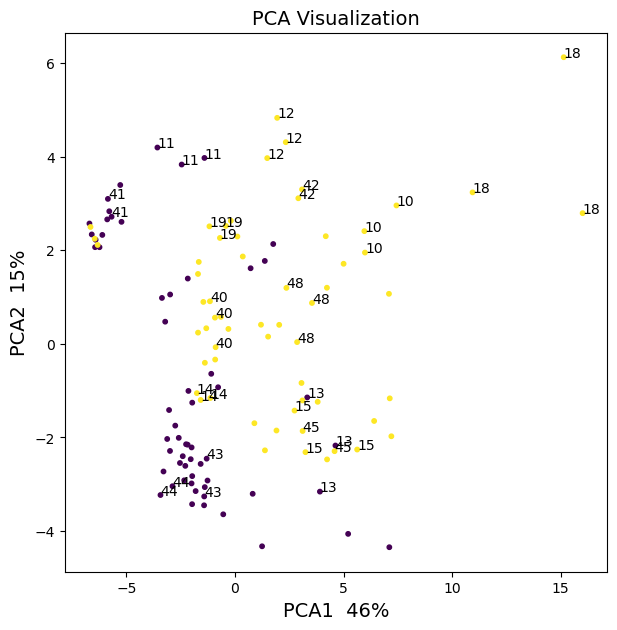

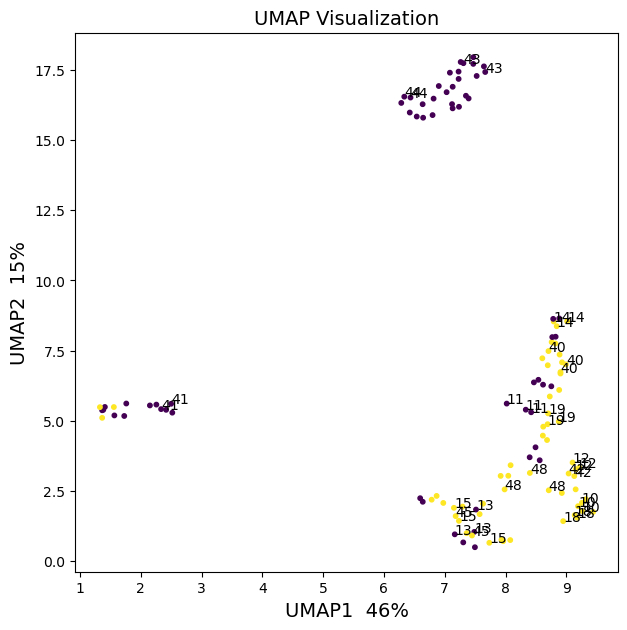

In [20]:
import matplotlib.pyplot as plt
import umap

# Assuming kvalitet_PCA1 and kvalitet_PCA2 are defined somewhere in your code
# Make sure to define them properly if not already done
with plt.ioff():
    figure, axis = plt.subplots(figsize=(7, 7))
    plt.xlabel("UMAP1" + "  " + kvalitet_PCA1 + "%")
    plt.ylabel("UMAP2" + "  " + kvalitet_PCA2 + "%")
    plt.title("UMAP Visualization")
    
    # Perform UMAP dimensionality reduction
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(finaldf3.iloc[:, :2])  # Assuming you want to reduce to 2 dimensions
    
    # Scatter plot the UMAP results
    plt.scatter(embedding[:, 0], embedding[:, 1], c=finaldf3.iloc[:, 2], s=10)
    
    # Annotate points with labels
    for i in range(40):
        plt.text(embedding[i, 0], embedding[i, 1], finaldf3.iloc[i, 3], fontsize=10)
    
    plt.show()


### To do: visualize TCC normalized, only TCC (as baseline), or combination TCC+feature normalized.

In [72]:
trip_sum_df.reset_index(drop=True, inplace=True)
trip_sum_df

NameError: name 'trip_sum_df' is not defined

In [22]:
trip_sum_df['y/n'].value_counts()

NameError: name 'trip_sum_df' is not defined

In [133]:
#trip_sum_df.corr()

## variable map

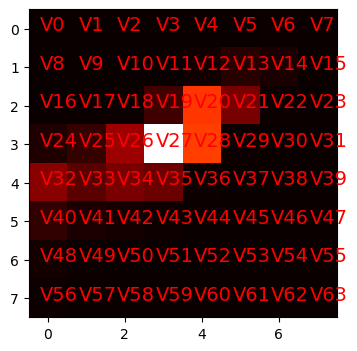

In [23]:
A=np.array(Df2.iloc[0,0:(pixels*pixels)])
B = np.reshape(A, (-1, pixels))
ax = plt.subplots(figsize=(4, 4))
plt.imshow(B,cmap='hot')
for j in range(pixels):
    for i in range(pixels):
        plt.text((i-0.2), j+0.05, Df2.iloc[:,0:(pixels*pixels)].columns.values[i+pixels*j],c='red')
plt.show()

### PCA total cellcount + cell distribution

In [73]:
principalComponents = pca.fit_transform(Df2.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
PCA_df.shape

(120, 2)

In [74]:
finalDf = pd.concat([PCA_df, Df2.iloc[:,-1]], axis = 1)
finalDf.head()

,0,1,y/n
0,3169.893910,-1756.127556,2
1,-608.693878,-2005.389104,2
2,4296.364074,-1637.223759,2
3,-2773.466081,-1567.470750,1
4,-1292.207576,-1529.055176,2


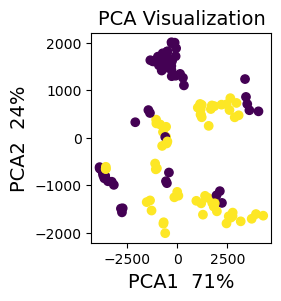

In [26]:
kvalitet=100*pca.explained_variance_ratio_
kvalitet_PCA1 = str(int(kvalitet[0]))
kvalitet_PCA2 = str(int(kvalitet[1]))


ax = plt.subplots(figsize=(3, 3))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)
plt.xlabel("PCA1"+"  "+kvalitet_PCA1+ "%")
plt.ylabel("PCA2"+"  "+kvalitet_PCA2+ "%")
plt.title("PCA Visualization")

plt.scatter(finalDf.iloc[:,0],finalDf.iloc[:,1],c=finalDf['y/n'])
plt.show()

### Normalized features , remove feature magnitude

In [75]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(Df2.iloc[:,0:-1])
df_norm_indata=pd.DataFrame(data=x) 
Df2_norm = pd.concat([df_norm_indata, Df2.iloc[:,-1]], axis = 1)
Df2.head(5)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,17.0,0.0,0.0,...,0.0,34.0,12.0,7.0,3.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,...,0.0,13.0,4.0,7.0,1.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,8.0,18.0,0.0,0.0,...,0.0,15.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,12.0,10.0,0.0,0.0,...,0.0,15.0,2.0,6.0,1.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,0.0,...,0.0,9.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,2


In [76]:
principalComponents = pca.fit_transform(Df2.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
finalDf_norm = pd.concat([PCA_df, Df2.iloc[:,-1]], axis = 1)
finalDf_norm.head()

,0,1,y/n
0,3169.893910,-1756.127556,2
1,-608.693878,-2005.389104,2
2,4296.364074,-1637.223759,2
3,-2773.466081,-1567.470750,1
4,-1292.207576,-1529.055176,2


<IPython.core.display.Javascript object>


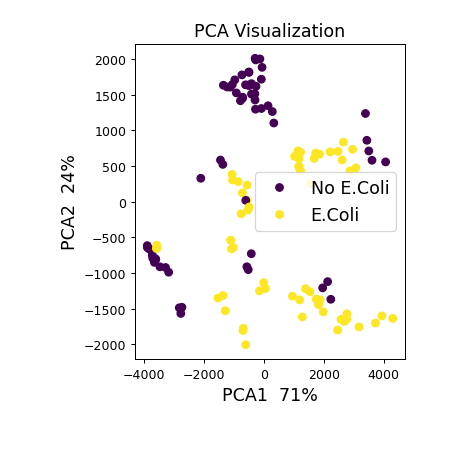

In [77]:
kvalitet=100*pca.explained_variance_ratio_
kvalitet_PCA1 = str(int(kvalitet[0]))
kvalitet_PCA2 = str(int(kvalitet[1]))

ax = plt.subplots(figsize=(5, 5))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)
plt.xlabel("PCA1"+"  "+kvalitet_PCA1+ "%")
plt.ylabel("PCA2"+"  "+kvalitet_PCA2+ "%")
plt.title("PCA Visualization")
scatter=plt.scatter(finalDf_norm.iloc[:,0],finalDf_norm.iloc[:,1],c=finalDf_norm['y/n'])

classes=['No E.Coli','E.Coli']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

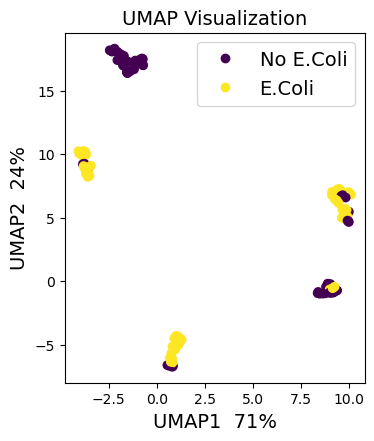

In [30]:
import matplotlib.pyplot as plt
import umap

# Compute quality metrics for UMAP
kvalitet = 100 * pca.explained_variance_ratio_
kvalitet_UMAP1 = str(int(kvalitet[0]))
kvalitet_UMAP2 = str(int(kvalitet[1]))

# Perform UMAP dimensionality reduction
reducer = umap.UMAP()
embedding = reducer.fit_transform(finalDf_norm.iloc[:, :2])  # Assuming you want to reduce to 2 dimensions

# Plot UMAP visualization
fig, ax = plt.subplots(figsize=(5, 5))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)
plt.xlabel("UMAP1" + "  " + kvalitet_UMAP1 + "%")
plt.ylabel("UMAP2" + "  " + kvalitet_UMAP2 + "%")
plt.title("UMAP Visualization")
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=finalDf_norm['y/n'])

# Add legend
classes = ['No E.Coli', 'E.Coli']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.show()

In [32]:
sum(pca.explained_variance_ratio_)

0.9581738811519126

In [33]:
pca = PCA(n_components=3)

In [78]:
principalComponents = pca.fit_transform(Df2.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
finalDf_norm = pd.concat([PCA_df, Df2.iloc[:,-1]], axis = 1)
finalDf_norm.head()

,0,1,y/n
0,3169.893910,-1756.127556,2
1,-608.693878,-2005.389104,2
2,4296.364074,-1637.223759,2
3,-2773.466081,-1567.470750,1
4,-1292.207576,-1529.055176,2


<IPython.core.display.Javascript object>


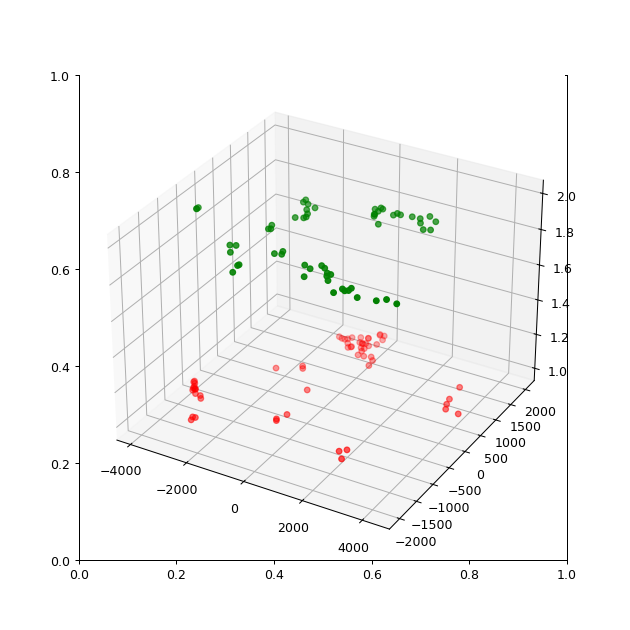

In [79]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(['r','b','g'])
%matplotlib notebook
ax = plt.subplots(figsize=(7, 7))
ax=plt.axes(projection='3d')
ax.scatter3D(finalDf_norm.iloc[:,0],finalDf_norm.iloc[:,1],finalDf_norm.iloc[:,2],c=finalDf_norm['y/n'],cmap=colors)

In [36]:
sum(pca.explained_variance_ratio_)

0.9832749169472291

### Feature importance Random Forest training on all data

In [95]:
#trip_sum_df

In [38]:
ran_for=RandomForestClassifier(n_estimators=1500)
X_train_array=np.array(Df2.iloc[:,0:-1])
y_train_array=np.array(Df2["y/n"])
ran_for.fit(X_train_array,y_train_array)
ran_for.feature_importances_
feature_df=pd.DataFrame(ran_for.feature_importances_,index=Df.iloc[:,0:(pixels*pixels)].columns.values,columns=["kol1"])
feature_df.sort_values(by=["kol1"],inplace=True,ascending=False)
feature_df[0:64]

,kol1
V20,0.115922
V28,0.066000
V21,0.055206
V14,0.054488
V24,0.048883
...,...
V30,0.000000
V31,0.000000
V1,0.000000
V38,0.000000


In [39]:
import pandas as pd

# Assuming feature_df is your DataFrame with features in the first column and importance values in the second row

# Sort DataFrame by the first column (features)
feature_df_sorted = feature_df.sort_values(by=feature_df.columns[0])

# Assuming the feature names are like V0, V1, ..., V63
feature_names_sorted = [f'V{i}' for i in range(64)]

# Reorder DataFrame columns based on the sorted feature names
feature_df_sorted = feature_df_sorted.reindex(feature_names_sorted)

# Display sorted DataFrame
print(feature_df_sorted)

         kol1
V0   0.000000
V1   0.000000
V2   0.000000
V3   0.000000
V4   0.000000
..        ...
V59  0.002938
V60  0.000096
V61  0.000000
V62  0.000000
V63  0.000000

[64 rows x 1 columns]


In [40]:
feature_df_sorted

,kol1
V0,0.000000
V1,0.000000
V2,0.000000
V3,0.000000
V4,0.000000
...,...
V59,0.002938
V60,0.000096
V61,0.000000
V62,0.000000


<IPython.core.display.Javascript object>


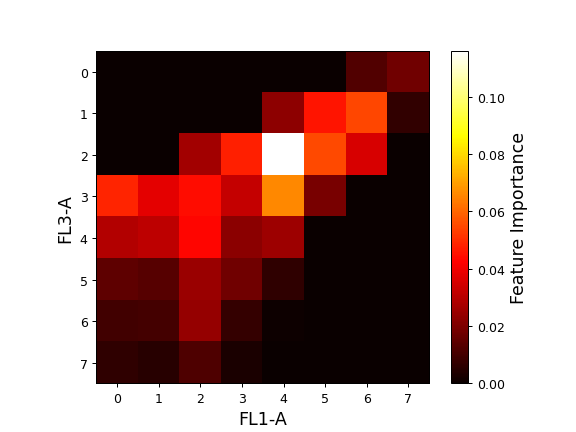

In [41]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming you have already calculated feature importance and created feature_df DataFrame

# Reshape feature importance values to the shape of your data
heatmap_data = feature_df_sorted["kol1"].values.reshape((pixels, pixels))

# Plot heatmap
plt.figure()
plt.imshow(heatmap_data, cmap="hot")
cbar = plt.colorbar()
cbar.set_label('Feature Importance', rotation=90)
#cbar.ax.set_yticklabels(['Not important', 'Very important'])
#plt.title('Feature Importance Heatmap')
plt.xlabel('FL1-A')
plt.ylabel('FL3-A')
plt.show()

<IPython.core.display.Javascript object>


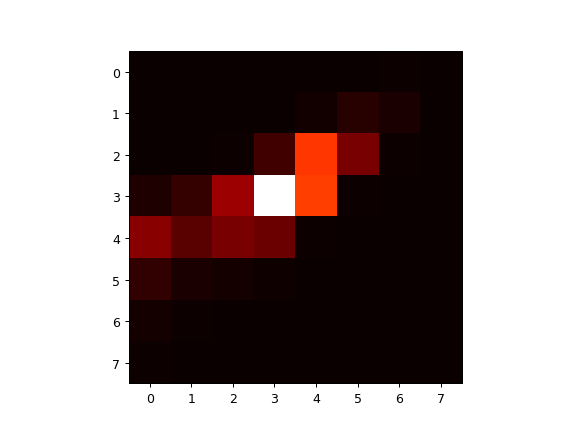

In [42]:
A=np.array(Df2.iloc[0,0:(pixels*pixels)])
B = np.reshape(A, (-1, pixels))
ax = plt.subplots()
plt.imshow(B,cmap='hot')
#for j in range(pixels):
   # for i in range(pixels):
        #plt.text((i-0.2), j+0.05, Df.iloc[:,0:(pixels*pixels)].columns.values[i+pixels*j],c='white')
plt.show()
# note: V27 not important at all ! V20,V22 most important for classification (Ran.for 1000 trees)

## Logistic regression

In [43]:
#trip_sum_df
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(Df2.iloc[:,0:-1])
df_norm_indata=pd.DataFrame(data=x) 
trip_sum_df_norm = pd.concat([df_norm_indata, Df2.iloc[:,-1]], axis = 1)
trip_sum_df_norm.head(5)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,4.514084,1.942978,0.0,0.0,...,0.0,3.723966,2.608709,0.617994,1.090596,-0.09167,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.068171,-0.782946,0.0,0.0,...,0.0,0.000000,-0.243638,0.617994,-0.324231,-0.09167,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.246007,2.124707,0.0,0.0,...,0.0,0.354663,-0.600181,-0.987185,0.383183,-0.09167,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.957353,0.670880,0.0,0.0,...,0.0,0.354663,-0.956725,0.296958,-0.324231,-0.09167,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.313026,1.034337,0.0,0.0,...,0.0,-0.709327,-0.243638,-0.345114,-1.031645,-0.09167,0.0,0.0,0.0,2


In [101]:
tabell=pd.DataFrame([[0,0,0,0]], columns=['Acc','Acc_1std','Sens','Sens_1std'])
tabell
accuracies=np.zeros(reruns)
sensitivities=np.zeros(reruns)
for j in range(reruns):
#for j in range(0):           
    X_train, X_test, y_train, y_test = train_test_split(trip_sum_df_norm.iloc[:,0:-1],trip_sum_df_norm[["y/n"]],test_size=0.2, random_state=None,stratify=trip_sum_df_norm[["y/n"]] )
    X_train_array=np.array(X_train)
    X_test_array=np.array(X_test)
    y_train_array=np.array(y_train['y/n'])
    y_test_array=np.array(y_test['y/n'])    
    
    log_reg.fit(X_train_array,y_train_array)
    ypred_test_array=log_reg.predict(X_test_array)
    
    TP=(np.logical_and((ypred_test_array==2),(y_test_array==2))).sum()
    TN=(np.logical_and((ypred_test_array==1),(y_test_array==1))).sum()
    FP=(np.logical_and((ypred_test_array==2),(y_test_array==1))).sum()
    FN=(np.logical_and((ypred_test_array==1),(y_test_array==2))).sum()

    accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracies[j]=accuracy
    sensitivity=(TP)/(TP+FN)
    sensitivities[j]=sensitivity
    
tabell.iloc[0,0]=np.mean(accuracies)  
tabell.iloc[0,1]=np.std(accuracies)
tabell.iloc[0,2]=np.mean(sensitivities)  
tabell.iloc[0,3]=np.std(sensitivities)
tabell

C:\Users\IsabelErb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\IsabelErb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\IsabelErb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\IsabelErb\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\IsabelErb\anaconda3\Lib\site-packages\s

,Acc,Acc_1std,Sens,Sens_1std
0,0.73175,0.130425,0.7125,0.216145


In [102]:
log_reg.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.19433649, -0.02104031,  0.        ,  0.        ,
         0.        ,  0.        ,  0.53610712,  3.75002046,  2.01781099,
        -0.17253021,  0.        ,  0.        ,  1.74679681,  4.12253785,
         3.8398381 , -4.70562788,  3.55144914,  0.        ,  1.40684477,
         4.34885205, -4.13643099,  3.51874965,  4.27212276, -2.90132579,
         0.        ,  0.        , -0.59157466,  5.57753155, -4.15713686,
        -0.98080253,  3.46720504,  0.        ,  0.        ,  0.        ,
        -3.56877469,  4.93360335, -2.75449607, -0.95586218,  6.54512044,
         0.        ,  0.        ,  0.        , -2.30544312,  2.60912965,
         2.62453347, -7.3852033 , -1.77613841,  0.        ,  0.        ,
         0.        ,  0.72394626,  8.13265057, -9.16334264, -4.40034682,
        -1.2893257 ,  0.        ,  0.        ,  0.        ]])

In [103]:
log_reg.intercept_

array([5.81431018])

In [82]:
trip_sum_df_norm

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,4.514084,1.942978,0.0,0.0,...,0.0,3.723966,2.608709,0.617994,1.090596,-0.09167,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.068171,-0.782946,0.0,0.0,...,0.0,0.000000,-0.243638,0.617994,-0.324231,-0.09167,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.246007,2.124707,0.0,0.0,...,0.0,0.354663,-0.600181,-0.987185,0.383183,-0.09167,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.957353,0.670880,0.0,0.0,...,0.0,0.354663,-0.956725,0.296958,-0.324231,-0.09167,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.313026,1.034337,0.0,0.0,...,0.0,-0.709327,-0.243638,-0.345114,-1.031645,-0.09167,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.0,0.0,0.0,0.0,0.0,0.0,-0.109666,-1.146403,0.0,0.0,...,0.0,-1.063990,-1.669811,-1.629257,-1.031645,-0.09167,0.0,0.0,0.0,2
116,0.0,0.0,0.0,0.0,0.0,0.0,0.246007,-0.237761,0.0,0.0,...,0.0,-1.241322,-0.243638,-0.666149,-0.324231,-0.09167,0.0,0.0,0.0,2
117,0.0,0.0,0.0,0.0,0.0,0.0,-0.109666,-0.056033,0.0,0.0,...,0.0,-0.177332,2.608709,0.617994,-0.324231,-0.09167,0.0,0.0,0.0,1
118,0.0,0.0,0.0,0.0,0.0,0.0,-0.821012,-0.782946,0.0,0.0,...,0.0,-0.531995,-0.956725,0.939030,-0.324231,-0.09167,0.0,0.0,0.0,1


### Random Forest better than LR.

In [52]:
ran_for=RandomForestClassifier(n_estimators=100)
tabell=pd.DataFrame([[0,0,0,0]], columns=['Acc','Acc_1std','Sens','Sens_1std'])
tabell
accuracies=np.zeros(reruns)
sensitivities=np.zeros(reruns)
for j in range(reruns):
#for j in range(0):           
    X_train, X_test, y_train, y_test = train_test_split(trip_sum_df_norm.iloc[:,0:-1],trip_sum_df_norm[["y/n"]],test_size=0.2, random_state=None,stratify=trip_sum_df_norm[["y/n"]] )
    X_train_array=np.array(X_train)
    X_test_array=np.array(X_test)
    y_train_array=np.array(y_train['y/n'])
    y_test_array=np.array(y_test['y/n'])    
    
    ran_for.fit(X_train_array,y_train_array)
    ypred_test_array=ran_for.predict(X_test_array)
    
    TP=(np.logical_and((ypred_test_array==2),(y_test_array==2))).sum()
    TN=(np.logical_and((ypred_test_array==1),(y_test_array==1))).sum()
    FP=(np.logical_and((ypred_test_array==2),(y_test_array==1))).sum()
    FN=(np.logical_and((ypred_test_array==1),(y_test_array==2))).sum()

    accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracies[j]=accuracy
    sensitivity=(TP)/(TP+FN)
    sensitivities[j]=sensitivity
    
tabell.iloc[0,0]=np.mean(accuracies)  
tabell.iloc[0,1]=np.std(accuracies)
tabell.iloc[0,2]=np.mean(sensitivities)  
tabell.iloc[0,3]=np.std(sensitivities)
tabell

C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_21512\2526897470.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9135833333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,0]=np.mean(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_21512\2526897470.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.054843907288473416' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,1]=np.std(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_21512\2526897470.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9286666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,2]=np.mean(sen

,Acc,Acc_1std,Sens,Sens_1std
0,0.913583,0.054844,0.928667,0.068072


In [57]:
sum(accuracies)/500

0.913583333333333

In [ ]:
def get_balanced_sample(X, y):
    classes = [1, 2,  3]  #Here we can adapt in case we want to do a two class classification 
    min_class_size = y.value_counts().min()
    
    balanced_data = [] # makes an epty list to store the balance dataset later  
    
    for cls in classes: # loop tat iterates trough each class 
        X_cls = X[y == cls] # subset of the fatures with corresponding y values 
        y_cls = y[y == cls] # subset of the target 
        
        if len(X_cls) > 0: # Just checking if there are any samples in the current class to ensure we dont resample an epty dataset 
            X_resampled, y_resampled = resample(X_cls, y_cls, 
                                                n_samples=min_class_size, 
                                                random_state=None) #set the randomste to NONE to ensure resampling is random eachtime
            #resample() is a function from scikit-learn used for random resampling, we only take as many samples as the smallest class size
            balanced_data.append((X_resampled, y_resampled))
    
    if balanced_data: #when there is data in balanced_data
        balanced_X = pd.concat([data[0] for data in balanced_data]) # makes a list that concats all the resampled data of features  in balanced_X 
        balanced_y = pd.concat([data[1] for data in balanced_data]) # makes a lsit that cancats all target values in balanced_y
    else: #when there is no data in balanced data 
        balanced_X = pd.DataFrame() #would create an empty dataframe
        balanced_y = pd.Series() #would create an empty sreies 
    
    return balanced_X, balanced_y

### Random Forest 2 threasholds , making use of the propabillity distribution

In [109]:
Thr_low=0.3
Thr_high=0.7
tabell=pd.DataFrame([[0,0,0,0,0,0]], columns=['Acc','Acc_1std','Sens','Sens_1std','IPF','IPF_1std'])

accuracies=np.zeros(reruns)
sensitivities=np.zeros(reruns)
IPFs=np.zeros(reruns)

for j in range(reruns):
#for j in range(0):        
    X_train, X_test, y_train, y_test = train_test_split(trip_sum_df_norm.iloc[:,0:-1],trip_sum_df_norm[["y/n"]],test_size=0.2, random_state=None,stratify=trip_sum_df_norm[["y/n"]] )

    X_train_array=np.array(X_train)
    X_test_array=np.array(X_test)
    y_train_array=np.array(y_train['y/n'])
    y_test_array=np.array(y_test['y/n'])    
    
    ran_for.fit(X_train_array,y_train_array)
    ypred_test_array=ran_for.predict_proba(X_test_array)[:,1]
    
    TP=(np.logical_and((ypred_test_array>Thr_high),(y_test_array==2))).sum()
    TN=(np.logical_and((ypred_test_array<Thr_low),(y_test_array==1))).sum()
    FP=(np.logical_and((ypred_test_array>Thr_high),(y_test_array==1))).sum()
    FN=(np.logical_and((ypred_test_array<Thr_low),(y_test_array==2))).sum()

    accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracies[j]=accuracy
    #sensitivity=(TP)/(TP+FN)
    #sensitivities[j]=sensitivity
    IPFs[j]=(TP+TN+FP+FN)/len(ypred_test_array)
    
tabell.iloc[0,0]=np.mean(accuracies)  
tabell.iloc[0,1]=np.std(accuracies)
#tabell.iloc[0,2]=np.mean(sensitivities)  
#tabell.iloc[0,3]=np.std(sensitivities)
tabell.iloc[0,4]=np.mean(IPFs)  
tabell.iloc[0,5]=np.std(IPFs)

tabell


C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_32412\56412099.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8848571428571429' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,0]=np.mean(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_32412\56412099.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.13423007121409342' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,1]=np.std(accuracies)
C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_32412\56412099.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabell.iloc[0,4]=np.mean(IPFs)
C:\Users\IsabelEr

,Acc,Acc_1std,Sens,Sens_1std,IPF,IPF_1std
0,0.884857,0.13423,0,0,0.666,0.158726


### Total cellcount prediction (same as with pixel=1 and max depth=1)

In [112]:
#Df2
%matplotlib inline

<Axes: >

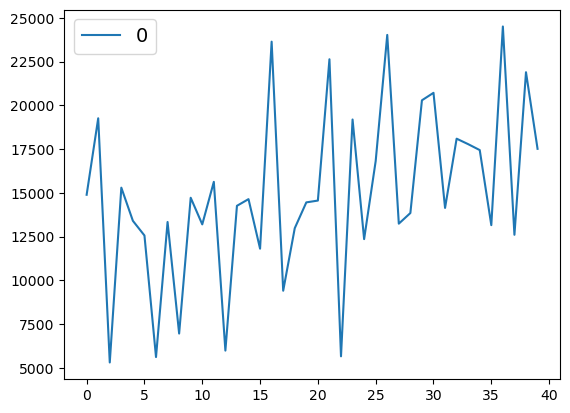

In [124]:
tcc=pd.DataFrame(Df2.iloc[:,0:-1].sum(axis=1))

tcc["y/n"]=Df2[["y/n"]]
nytcc=tcc.sort_values(by=["y/n"])
nytcc = nytcc.reset_index()
del nytcc['index']
nytcc.iloc[:,0:-1].plot()


In [114]:
nytcc.corr()

,0,y/n
0,1.000000,0.419853
y/n,0.419853,1.000000


In [115]:
Df2=Df.drop('ECOLI',axis=1)
tripnames=[]
files=metadata2.iloc[0]
files_a=files[1]+".fcs";files_b=files[2]+".fcs";files_c=files[3]+".fcs"
trip1=Df2.loc[[files_a]]
trip2=Df2.loc[[files_b]]
trip3=Df2.loc[[files_c]]
trip=pd.concat([trip1,trip2,trip3],axis=0)
trip_sum=trip.iloc[:,0:(trip.shape[1]-1)].sum(axis=0)
trip_sum_df=pd.DataFrame(data=trip_sum).transpose()
trip_sum_df["y/n"]=trip["y/n"][0]
tripnames.append(files_a)
for i in range(1,40):
    files=metadata2.iloc[i]
    files_a=files[1]+".fcs";files_b=files[2]+".fcs";files_c=files[3]+".fcs"
    trip1=Df2.loc[[files_a]]
    trip2=Df2.loc[[files_b]]
    trip3=Df2.loc[[files_c]]
    trip=pd.concat([trip1,trip2,trip3],axis=0)
    trip_sum=trip.iloc[:,0:(trip.shape[1]-1)].sum(axis=0)
    trip_sum_df2=pd.DataFrame(data=trip_sum).transpose()
    trip_sum_df2["y/n"]=trip["y/n"][0]
    trip_sum_df=pd.concat([trip_sum_df,trip_sum_df2],axis=0)
    tripnames.append(files_a)
#trip_sum_df.shape
#trip_sum_df

C:\Users\IsabelErb\AppData\Local\Temp\ipykernel_32412\1917262094.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  files_a=files[1]+".fcs";files_b=files[2]+".fcs";files_c=files[3]+".fcs"


KeyError: "None of [Index(['A03 B1 1-20 b v28 SY.fcs'], dtype='object')] are in the [index]"

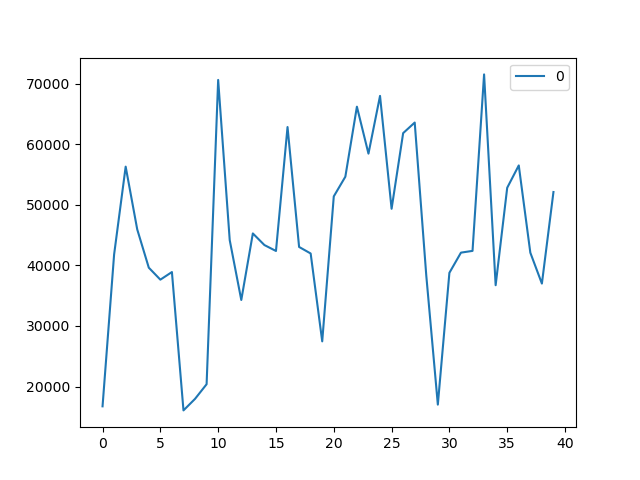

In [138]:
tcc=pd.DataFrame(trip_sum_df.iloc[:,0:-1].sum(axis=1))

tcc["y/n"]=trip_sum_df[["y/n"]]
nytcc=tcc.sort_values(by=["y/n"])
nytcc = nytcc.reset_index()
del nytcc['index']
nytcc.iloc[:,0:-1].plot()

### Total cellcount correlation

In [139]:
nytcc.corr()

,0,y/n
0,1.000000,0.365898
y/n,0.365898,1.000000


In [140]:
trip_sum_df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,72.0,0.0,0.0,...,0.0,80.0,22.0,18.0,8.0,0.0,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,11.0,0.0,0.0,...,0.0,49.0,28.0,9.0,6.0,0.0,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,36.0,0.0,0.0,...,0.0,48.0,25.0,21.0,8.0,0.0,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,17.0,0.0,0.0,...,0.0,45.0,16.0,16.0,14.0,0.0,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,11.0,0.0,0.0,...,0.0,39.0,15.0,12.0,5.0,0.0,0.0,0.0,0.0,2


In [183]:
testdf=pd.DataFrame([[2,3],[4,5]])
#testdf

In [180]:
testny=testdf.div(testdf.sum(axis=1),axis=0)

In [184]:
#testdf

In [185]:
#testny

In [141]:
trip_sum_df_features=trip_sum_df.drop('y/n',axis=1)
trip_sum_df_features.head(3)


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63
0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,72.0,0.0,0.0,...,0.0,0.0,80.0,22.0,18.0,8.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,11.0,0.0,0.0,...,0.0,0.0,49.0,28.0,9.0,6.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,36.0,0.0,0.0,...,0.0,0.0,48.0,25.0,21.0,8.0,0.0,0.0,0.0,0.0


In [142]:
trip_sum_df_TCCnorm_features=trip_sum_df_features.div(trip_sum_df_features.sum(axis=1),axis=0)

In [143]:
trip_sum_df_TCCnorm_features.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63
0,0.0,0.0,0.0,0.0,0.0,0.0,0.001338,0.001059,0.0,0.0,...,0.0,0.0,0.001176,0.000324,0.000265,0.000118,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000214,0.000261,0.0,0.0,...,0.0,0.0,0.001164,0.000665,0.000214,0.000142,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000849,0.000637,0.0,0.0,...,0.0,0.0,0.000849,0.000442,0.000372,0.000142,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000416,0.000322,0.0,0.0,...,0.0,0.0,0.000852,0.000303,0.000303,0.000265,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000408,0.000299,0.0,0.0,...,0.0,0.0,0.001062,0.000408,0.000327,0.000136,0.0,0.0,0.0,0.0


In [144]:
trip_sum_df_TCCnorm = pd.concat([trip_sum_df_TCCnorm_features, trip_sum_df[['y/n']]], axis = 1)
trip_sum_df_TCCnorm

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,0.001338,0.001059,0.0,0.0,...,0.0,0.001176,0.000324,0.000265,0.000118,0.000000,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000214,0.000261,0.0,0.0,...,0.0,0.001164,0.000665,0.000214,0.000142,0.000000,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000849,0.000637,0.0,0.0,...,0.0,0.000849,0.000442,0.000372,0.000142,0.000000,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000416,0.000322,0.0,0.0,...,0.0,0.000852,0.000303,0.000303,0.000265,0.000000,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000408,0.000299,0.0,0.0,...,0.0,0.001062,0.000408,0.000327,0.000136,0.000000,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000419,0.000615,0.0,0.0,...,0.0,0.000601,0.000224,0.000098,0.000056,0.000000,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000143,0.000111,0.0,0.0,...,0.0,0.000779,0.000350,0.000223,0.000127,0.000000,0.0,0.0,0.0,1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000377,0.000330,0.0,0.0,...,0.0,0.001061,0.000377,0.000377,0.000094,0.000000,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000380,0.000617,0.0,0.0,...,0.0,0.000855,0.000237,0.000261,0.000024,0.000000,0.0,0.0,0.0,2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000335,0.000413,0.0,0.0,...,0.0,0.001134,0.000335,0.000335,0.000000,0.000000,0.0,0.0,0.0,2


In [158]:
tcc_test=pd.DataFrame(trip_sum_df_TCCnorm.iloc[:,0:-1].sum(axis=1))
tcc_test

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [209]:
#tcc_test

In [147]:
trip_sum_df_TCCnorm.reset_index(drop=True, inplace=True)
trip_sum_df_TCCnorm

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,0.001338,0.001059,0.0,0.0,...,0.0,0.001176,0.000324,0.000265,0.000118,0.000000,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000214,0.000261,0.0,0.0,...,0.0,0.001164,0.000665,0.000214,0.000142,0.000000,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000849,0.000637,0.0,0.0,...,0.0,0.000849,0.000442,0.000372,0.000142,0.000000,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000416,0.000322,0.0,0.0,...,0.0,0.000852,0.000303,0.000303,0.000265,0.000000,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000408,0.000299,0.0,0.0,...,0.0,0.001062,0.000408,0.000327,0.000136,0.000000,0.0,0.0,0.0,2
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000419,0.000615,0.0,0.0,...,0.0,0.000601,0.000224,0.000098,0.000056,0.000000,0.0,0.0,0.0,2
6,0.0,0.0,0.0,0.0,0.0,0.0,0.000143,0.000111,0.0,0.0,...,0.0,0.000779,0.000350,0.000223,0.000127,0.000000,0.0,0.0,0.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000377,0.000330,0.0,0.0,...,0.0,0.001061,0.000377,0.000377,0.000094,0.000000,0.0,0.0,0.0,2
8,0.0,0.0,0.0,0.0,0.0,0.0,0.000380,0.000617,0.0,0.0,...,0.0,0.000855,0.000237,0.000261,0.000024,0.000000,0.0,0.0,0.0,2
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000335,0.000413,0.0,0.0,...,0.0,0.001134,0.000335,0.000335,0.000000,0.000000,0.0,0.0,0.0,2


### TCC normalized and then feature normalized PCA

In [148]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(trip_sum_df_TCCnorm.iloc[:,0:-1])
df_norm_indata=pd.DataFrame(data=x) 
trip_sum_df_TCCnorm_norm = pd.concat([df_norm_indata, trip_sum_df_TCCnorm.iloc[:,-1]], axis = 1)
trip_sum_df_TCCnorm_norm.head(5)

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,y/n
0,0.0,0.0,0.0,0.0,0.0,0.0,2.833289,1.875127,0.0,0.0,...,0.0,1.163728,-0.006700,-0.572793,0.317639,-0.160128,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,-0.785464,-0.491003,0.0,0.0,...,0.0,1.108746,2.387589,-0.924847,0.687278,-0.160128,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,1.259886,0.623685,0.0,0.0,...,0.0,-0.251398,0.826447,0.165607,0.673180,-0.160128,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.133142,-0.311365,0.0,0.0,...,0.0,-0.240515,-0.151522,-0.309075,2.509349,-0.160128,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,-0.159186,-0.377641,0.0,0.0,...,0.0,0.667431,0.588096,-0.144544,0.592375,-0.160128,0.0,0.0,0.0,2


In [149]:
principalComponents = pca.fit_transform(trip_sum_df_TCCnorm_norm.iloc[:,0:-1])
PCA_df=pd.DataFrame(principalComponents)
finalDf_norm = pd.concat([PCA_df, trip_sum_df_TCCnorm_norm.iloc[:,-1]], axis = 1)
finalDf_norm.head()

,0,1,y/n
0,9.552074,5.490497,2
1,2.683442,6.654867,2
2,3.615718,2.995302,2
3,2.031613,2.344676,2
4,3.599875,1.324401,2


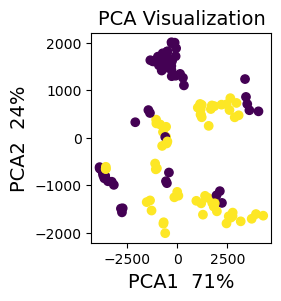

In [30]:
kvalitet=100*pca.explained_variance_ratio_
kvalitet_PCA1 = str(int(kvalitet[0]))
kvalitet_PCA2 = str(int(kvalitet[1]))

ax = plt.subplots(figsize=(3, 3))
plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.2)
plt.xlabel("PCA1"+"  "+kvalitet_PCA1+ "%")
plt.ylabel("PCA2"+"  "+kvalitet_PCA2+ "%")
plt.title("PCA Visualization")
plt.scatter(finalDf_norm.iloc[:,0],finalDf_norm.iloc[:,1],c=finalDf_norm['y/n'])
plt.show()

### Random forest on TCC normalized data

In [153]:
ran_for=RandomForestClassifier(n_estimators=100)
tabell=pd.DataFrame([[0,0,0,0]], columns=['Acc','Acc_1std','Sens','Sens_1std'])
tabell
accuracies=np.zeros(reruns)
sensitivities=np.zeros(reruns)
for j in range(reruns):
#for j in range(0):           
    X_train, X_test, y_train, y_test = train_test_split(trip_sum_df_TCCnorm.iloc[:,0:-1],trip_sum_df_TCCnorm[["y/n"]],test_size=0.2, random_state=None,stratify=trip_sum_df_TCCnorm[["y/n"]] )
    X_train_array=np.array(X_train)
    X_test_array=np.array(X_test)
    y_train_array=np.array(y_train['y/n'])
    y_test_array=np.array(y_test['y/n'])    
    
    ran_for.fit(X_train_array,y_train_array)
    ypred_test_array=ran_for.predict(X_test_array)
    
    TP=(np.logical_and((ypred_test_array==2),(y_test_array==2))).sum()
    TN=(np.logical_and((ypred_test_array==1),(y_test_array==1))).sum()
    FP=(np.logical_and((ypred_test_array==2),(y_test_array==1))).sum()
    FN=(np.logical_and((ypred_test_array==1),(y_test_array==2))).sum()

    accuracy=(TP+TN)/(TP+TN+FP+FN)
    accuracies[j]=accuracy
    sensitivity=(TP)/(TP+FN)
    sensitivities[j]=sensitivity
    
tabell.iloc[0,0]=np.mean(accuracies)  
tabell.iloc[0,1]=np.std(accuracies)
tabell.iloc[0,2]=np.mean(sensitivities)  
tabell.iloc[0,3]=np.std(sensitivities)
tabell

,Acc,Acc_1std,Sens,Sens_1std
0,0.78225,0.145529,0.8575,0.177676
